# Exploring Data Summary from TILDE, Application to envirosensor data

## &nbsp;Table of contents
### 1. Introduction
### 2. Building the Basic TILDE Query
### 3. Building a TILDE Query with a specific domain
### 4. Find station locations and display on a map
### 5. Station data and data range graphs

## &nbsp;1. Introduction

In this tutorial we will be learning how to use Python to query the TILDE API `Data Summary` endpoint. To highlight different functionalities and the data available we will be using the envirosensor (Environmental Sensor) dataset. This dataset is derived from GeoNet's Low Rate Data Collection Platform (LRDCP). TILDE is the API (Application Programmatic Interface) to access envirosensor data. You do not need to know anything about APIs to use this tutorial. If you would like more info see https://tilde.geonet.org.nz/v2/api-docs/.

This tutorial assumes you have basic knowledge of Python.

###### About GeoNet envirosensor data and the Low Rate Data Collection Platform

GeoNet currently has 6 environmental stations at various locations across Mt Ngauruhoe, Mt Tongariro, Waimangu Volcanic Valley and Rotoma Soda Springs to measure various factors related to volcano/thermal indicators. These include measuring; air temperature, fumarole temperature, lake height, lake temperature, overflow temperature, spring height and spring temperature. Most of these sites measure 2-3 of these factors. Different aspects can also be selected if there are more than one measure at a site, for example there is a south-vent and an east-vent aspect for fumarole temperature at one of the Tongariro sites (TO006). The envirosensors are part of the Low Rate Data Collection Platform (LRDCP). TILDE provides access to minimum, the maximum and the snapshot data. 

A web page providing more information on the LRDCP is in planning/preparation.

## &nbsp;2. Building the Basic TILDE Query

###### Import required modules and set the source URL

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import OSM

In [2]:
source = 'https://tilde.geonet.org.nz'

### A basic query with no parameters applied

This query returns information on the different data domains held in TILDE. The query uses the 'dataSummary' endpoint as `https://tilde.geonet.org.nz/v2/dataSummary/`.

######  Set the URL of a basic data summary query

In [3]:
url = source+'/v2/dataSummary/'

In [4]:
r = requests.get(url)
print (r)

<Response [200]>


We use `requests.get` to retrieve the data from the URL. The response status code says whether we were successful in getting the data requested and why not if we were unsuccessful:
<ul>
<li>200 -- everything went okay, and the result has been returned (if any)
<li>301 -- the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
<li>400 -- the server thinks you made a bad request. This can happen when you don't send along the right data, among other things.
<li>404 -- the resource you tried to access wasn't found on the server.
</ul>

###### Store the response as a nested dictionary and see the output

A nested dictionary in python is a dictionary within a dictionary. It's a collection of dictionaries into one single directory. <br>
In TILDE, each data domain has different entries which sit within that specific domain name. For example, DART data sit within the _dart_ domain, and the envirosensor data sit within the _envirosensor_ domain. By creating a nested dictionary we can specify the domain and then split it by domain name. 

In [5]:
summary = r.json()
type(summary)

dict

In [6]:
summary

{'domains': {'dart': {'domain_name': 'dart',
   'description': 'Deep-ocean Assessment and Reporting of Tsunami',
   'recordCount': 1424825,
   'seriesCount': 64,
   'stationCount': 12,
   'earliestRecord': '2019-12-13T02:15:00Z',
   'latestRecord': '2022-04-27T12:00:00Z'},
  'envirosensor': {'domain_name': 'envirosensor',
   'description': 'Environmental Sensors',
   'recordCount': 361118,
   'seriesCount': 54,
   'stationCount': 6,
   'earliestRecord': '2022-02-24T04:00:00Z',
   'latestRecord': '2022-04-27T15:50:00Z'}}}

######  Specifying the domains from the summary

Currently only the DART and envirosensor domains exist in TILDE. As more domains become available more details will be shown here. 

In [7]:
domains = summary['domains']
domains

{'dart': {'domain_name': 'dart',
  'description': 'Deep-ocean Assessment and Reporting of Tsunami',
  'recordCount': 1424825,
  'seriesCount': 64,
  'stationCount': 12,
  'earliestRecord': '2019-12-13T02:15:00Z',
  'latestRecord': '2022-04-27T12:00:00Z'},
 'envirosensor': {'domain_name': 'envirosensor',
  'description': 'Environmental Sensors',
  'recordCount': 361118,
  'seriesCount': 54,
  'stationCount': 6,
  'earliestRecord': '2022-02-24T04:00:00Z',
  'latestRecord': '2022-04-27T15:50:00Z'}}

**Access Method 1 - Use the items method to access each entry**
<br>
To have actual information about the domain you can print out the key-value pairs as shown below. In this case we print out various item names that have been returned for the _dart_ and _envirosensor_ domain in the response above. We are printing out each item line by line, with the domain name being at the top. 

In [8]:
#iterate over key,value pairs and print the results
for domain,detail in domains.items():
    print ('For Domain = ', domain)     
    print ('\tDomain name =', detail.get('domain_name'))
    print ('\tDescription =', detail.get('description'))
    print ('\tRecord count =', detail.get('recordCount'))
    print ('\tSeries count =', detail.get('seriesCount'))
    print ('\tStation count =', detail.get('stationCount'))
    print ('\tEarliest record =', detail.get('earliestRecord'))
    print ('\tLatest record =', detail.get('latestRecord'))

For Domain =  dart
	Domain name = dart
	Description = Deep-ocean Assessment and Reporting of Tsunami
	Record count = 1424825
	Series count = 64
	Station count = 12
	Earliest record = 2019-12-13T02:15:00Z
	Latest record = 2022-04-27T12:00:00Z
For Domain =  envirosensor
	Domain name = envirosensor
	Description = Environmental Sensors
	Record count = 361118
	Series count = 54
	Station count = 6
	Earliest record = 2022-02-24T04:00:00Z
	Latest record = 2022-04-27T15:50:00Z


**Access Method 2 - Summary info in table format**
<br>
Pandas dataframes can be quite useful because they enable the user to visualize information in a table instead of line-by-line as shown above. The dataframe calls for the values in the 'domains' variable that we set above and then the 'orient' (orientation) is specified to be the 'index' because we are using the highest level key as the index, and subsidiary keys as columns. As we have two domains, they each have a row in the table, adding more domains would create more rows.

In [9]:
df = pd.DataFrame.from_dict(data=domains, orient='index')
df

,domain_name,description,recordCount,seriesCount,stationCount,earliestRecord,latestRecord
dart,dart,Deep-ocean Assessment and Reporting of Tsunami,1424825,64,12,2019-12-13T02:15:00Z,2022-04-27T12:00:00Z
envirosensor,envirosensor,Environmental Sensors,361118,54,6,2022-02-24T04:00:00Z,2022-04-27T15:50:00Z


## &nbsp;3. Building a TILDE Query with a specific domain, and seeing what data that domain contains

This query returns information about the specific data domains provided. <br> 
The query is `https://tilde.geonet.org.nz/v2/dataSummary/[domain]`. For this example we will continue to use the envirosensor domain.

######  Exploring summary for the envirosensor domain
<br>
Following the same steps as above but specifying 'envirosensor' domain after 'dataSummary'. This produces a long list of all the details of the 'envirosensor' data.

In [10]:
mydomain = 'envirosensor'
url = 'https://tilde.geonet.org.nz/v2/dataSummary/'+mydomain
r = requests.get(url)
summary = r.json()

Each station in the envirosensor domain provides several data series, and virtually no two stations are alike. This makes for a long, complex data summary. And the JSON format doesn't make it easy to read. It will be very useful if we can list each of the stations and exactly what data streams are in each records in a table-like format. We'll make a pandas dataframe for this.

We do this with a function and then call it with the output going to a dataframe.

In [11]:
def station_data(summary, domain):
    #dataframe for results
    df = pd.DataFrame()
    
    #select just station part of dictionary
    stations = summary['domain'][domain]['stations']

    #get list of stations
    # print ('##Station locations##')
    stationlist = []
    for key,val in stations.items():
        stationlist.append(key)
        # print (key, val['station_name'], val['latitude'], val['longitude'])

    #with each station, get the location information, and the sensor_codes part of the dictionary
    # print('\n')
    # print ('##Station details##')
    for sta in stationlist:
        # print ('##'+sta+'##')
        latitude = stations[sta].get('latitude')
        longitude = stations[sta].get('longitude')
        sensorcodes = stations[sta]['sensor_codes']
        # print (sensorcodes)

        codelist = []
        for key,val in sensorcodes.items():
            codelist.append(key)
            # print ('sensor code = ', val['sensor_code'])
            
        #get the names part
        for code in codelist:
            # print ('code=',code)
            names = sensorcodes[code]['names']

            namelist = []
            for key,val in names.items():
                namelist.append(key)
                # print (sta, code, val['measure_name'])

            #get the methods part    
            for name in namelist:
                # print ('name='+name)
                methods = names[name]['methods']

                methodlist = []
                for key,val in methods.items():
                    methodlist.append(key)
                    
                #get the aspects part    
                for method in methodlist:
                    # print ('method=', method)
                    aspects  = methods[method]['aspects']

                    aspectlist = []
                    for key,val in aspects.items():
                        aspectlist.append(key)
                        # print (sta, code, name, method, val['aspect'])
                        
                        #get the record data
                        for aspect in aspectlist:
                                # print ('aspect=', aspect)
                                records = aspects[aspect]
                                recordcount = records.get('recordCount')
                                earliestrecord = records.get('earliestRecord')
                                latestrecord = records.get('latestRecord')
                                # print (recordcount, earliestrecord, latestrecord)
                                            
                                d = {'station':sta, 'latitude':latitude, 'longitude':longitude, 'sensor_code':code, 'data_name':name, 'data_method':method, 'aspect':aspect, 'record_count':recordcount, 'earliestrecord':earliestrecord, 'latestrecord':latestrecord}
                                df = df.append(d, ignore_index=True)

    df['earliestrecord'] = pd.to_datetime(df['earliestrecord'])
    df['latestrecord'] = pd.to_datetime(df['latestrecord'])
    return(df)

In [12]:
#call function to get main station data, supply the domain name
station_data = station_data(summary, mydomain)
station_data.head(20)

,station,latitude,longitude,sensor_code,data_name,data_method,aspect,record_count,earliestrecord,latestrecord
0,NA002,-39.1564,175.6347,01,air-temperature,max,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
1,NA002,-39.1564,175.6347,01,air-temperature,min,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
2,NA002,-39.1564,175.6347,01,air-temperature,snapshot,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
3,NA002,-39.1564,175.6347,02,fumarole-temperature,max,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
4,NA002,-39.1564,175.6347,02,fumarole-temperature,min,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
5,NA002,-39.1564,175.6347,02,fumarole-temperature,snapshot,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
6,NA002,-39.1564,175.6347,03,fumarole-temperature,max,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
7,NA002,-39.1564,175.6347,03,fumarole-temperature,min,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
8,NA002,-39.1564,175.6347,03,fumarole-temperature,snapshot,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
9,OT001,-38.2819,176.3997,01,lake-temperature,max,nil,6565.0,2022-02-24 04:00:00+00:00,2022-04-27 15:40:00+00:00


## &nbsp;4. Find station locations and display on a map

**Access Method 1 - Using the specific key for station metadata**
<br>
Using the summary file we can access the envirosensor station locations

In [13]:
mydomain='envirosensor'
stations = summary['domain'][mydomain]['stations']

Using stations.items we can specify what variables we are after, e.g. station_name, latitude, longitude and then print these. The key used is also the station_name. 

In [14]:
for key,val in stations.items():
    print (key, val['station_name'], val['latitude'], val['longitude'])

NA002 NA002 -39.1564 175.6347
OT001 OT001 -38.2819 176.3997
OT013 OT013 -38.0385 176.5495
TO003 TO003 -39.1097 175.6721
TO006 TO006 -39.1092 175.6682
TO015 TO015 -39.1062 175.6699


**Access Method 2 - Direct to a Pandas dataframe**
<br>
For easier reading we can make this information into a pandas dataframe where we are only focusing on station_name, latitude, and longitude. Which we can specify using `columns=[]`. So the station becomes the dataframe index and the other keys the column names. 

In [15]:
df = pd.DataFrame.from_dict(data=stations, orient='index', columns=['station_name', 'latitude', 'longitude'])
df

,station_name,latitude,longitude
NA002,NA002,-39.1564,175.6347
OT001,OT001,-38.2819,176.3997
OT013,OT013,-38.0385,176.5495
TO003,TO003,-39.1097,175.6721
TO006,TO006,-39.1092,175.6682
TO015,TO015,-39.1062,175.6699


**Map the positions, using the dataframe as the data source**
<br>
Using cartopy https://scitools.org.uk/cartopy/docs/latest/index.html and matplotlib we can then generate a map of the stations using the values (station_name, latitude and longitude) from the pandas dataframe `df` that we generated in the step above. Using the station_name variable we can also plot the names next to the stations using `ax.text`. 
<br>
Our stations providing envirosensor data are clustered in groups so we'll focus our map on just one of those groups, showing stations starting with the TO prefix. We'll also use Open Street Map map tiles to get a map background that gives some context.

In [16]:
#Select the stations in our map area
xmin = 175.66
xmax = 175.68
ymin = -39.12
ymax = -39.10
plotstations = df[(df['longitude']>=xmin) & (df['longitude']<=xmax) & (df['latitude']>=ymin) & (df['latitude']<=ymax)]
plotstations

,station_name,latitude,longitude
TO003,TO003,-39.1097,175.6721
TO006,TO006,-39.1092,175.6682
TO015,TO015,-39.1062,175.6699


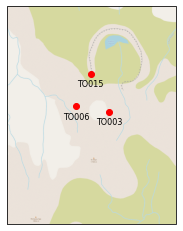

In [17]:
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([xmin, xmax, ymin, ymax])
#if you don't set the map extent, it will zoom to a suitable scale of it's choice
ax.add_image(imagery, 16)

xx = plotstations['longitude'].values
yy = plotstations['latitude'].values
names = plotstations['station_name'].values
ax.plot(xx, yy, color='red', marker='o', linestyle='None', transform=ccrs.Geodetic())

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-10)

for x, y, n in zip(xx, yy, names):
    ax.text(x, y, n, fontsize=8, verticalalignment='center', horizontalalignment='center', transform=text_transform)
             

## &nbsp;5. Station data and data plots

#### Use the dataframe of station record data (number, earliest, latest) created earlier, and visualize this in different ways
The data frame we are using is called `station_data`, and was created in Section 3 `Building a TILDE Query with a specific domain, and seeing what data that domain contains`

Use `station_data.head()` to see only the first few lines. If we used `station_data.tail()` we can see the last few lines. 

In [18]:
station_data.head()

,station,latitude,longitude,sensor_code,data_name,data_method,aspect,record_count,earliestrecord,latestrecord
0,NA002,-39.1564,175.6347,01,air-temperature,max,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
1,NA002,-39.1564,175.6347,01,air-temperature,min,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
2,NA002,-39.1564,175.6347,01,air-temperature,snapshot,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
3,NA002,-39.1564,175.6347,02,fumarole-temperature,max,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00
4,NA002,-39.1564,175.6347,02,fumarole-temperature,min,nil,8682.0,2022-02-24 04:00:00+00:00,2022-04-27 15:50:00+00:00


**Record count by station and sensor code**
<br>
By using `pd.pivot_table` we can transform the above table, so we can look at record_counts for each sensor_code at each station. The sensor_code is the number assigned to each physical sensor at a station. Not all stations have the same number of sensors, so at some stations the record_count will not be defined for some sensor_codes, and will be shown as `NaN`.

In [19]:
rc = pd.pivot_table(station_data, index='station', values=['record_count'], columns='sensor_code')
rc.head()

record_count                             
sensor_code           01      02           03      04
station                                              
NA002             8682.0  8682.0  8682.000000     NaN
OT001             6565.0  6565.0  6554.666667   830.0
OT013             9000.0  9000.0          NaN     NaN
TO003             8994.0  8994.0  8994.000000  8994.0
TO006              612.0   612.0   612.000000     NaN

We can then plot this as a bar plot using `plot.bar`. This allows us to visualize the number of records for each station. We don't expect to see the same number of records for each station, but we should, largely, see the same number for each sensor_code, unless an extra sensor has been added after the station was installed.

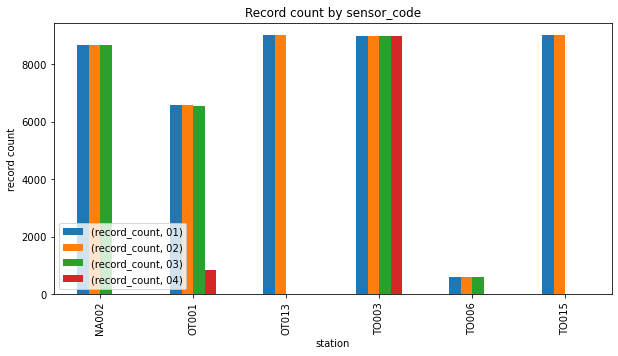

In [20]:
ax = rc.plot.bar(figsize=(10,5))
ax.set_ylabel('record count')
ax.set_title('Record count by sensor_code')
ax.legend(loc='lower left');

**Creating a data time-range plot, with stations split by sensor_code**

Our intention is to show graphically the available data, and to do that by station and sensor_code. Most stations collect data with more than one data_method, but these are all collected at the same time, so the number of `snapshot`, `min`, and `max` should always be the same. We'll therefore only display the data range for the `snapshot` data_method. So we first select only the records that have a`data_method` of `snapshot` and add then to a new dataframe called `snapshot`. <br>
Creating a dataframe with a new column entry 'stasen' which combines the station and sensor_code columns, this will produce a column with values such as NA002_01, OT013_02, TO006_01,...etc that we will subsequently use as y-axis labels. This step will give you a copy warning which you can usualy safely ignore. We can then sort by this column using `snapshot.sort_values` and specifying the 'stasen' column which we just generated. To view the output of this, add `snapsorted` or `snapsorted.head()` to a new line in the code cell below and run.

In [21]:
snapshot = station_data[station_data['data_method']=='snapshot']
snapshot['stasen'] = snapshot['station'] + '_' + snapshot['sensor_code']
snapsorted = snapshot.sort_values('stasen')

/home/mkortink/miniforge3/envs/GeoNet/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We now want to make a new column called 'pos' that will be the position on the y-axis to plot the data range line. `len(snapsorted)` gets the number of rows in the dataframe. Using `len(snapsorted) - np.arange(len(snapsorted))` we start with the total number of rows and then with each row our position reduces by 1. This allows us to have a position value for each row. 

In [22]:
snapsorted['pos'] = len(snapsorted) - np.arange(len(snapsorted))

Now we can set up the labeling for station name vs yvalue. To set the variable 'station_list' we use the 'stadat' values from the dataframe, this way we will have entries for each station, sensor_code, data_method combination. The yvals are used to set the spacing between the yticks in the next plot. By using `range` which is `range([start], stop [,step])`. We can generate a list that starts at the number of station-sesnor_code pairs, stops at 0 and steps by -1.

In [23]:
station_list = snapsorted['stasen'].values
yvals = range((len(snapsorted)),0,-1)

Now we want to visualise this data.

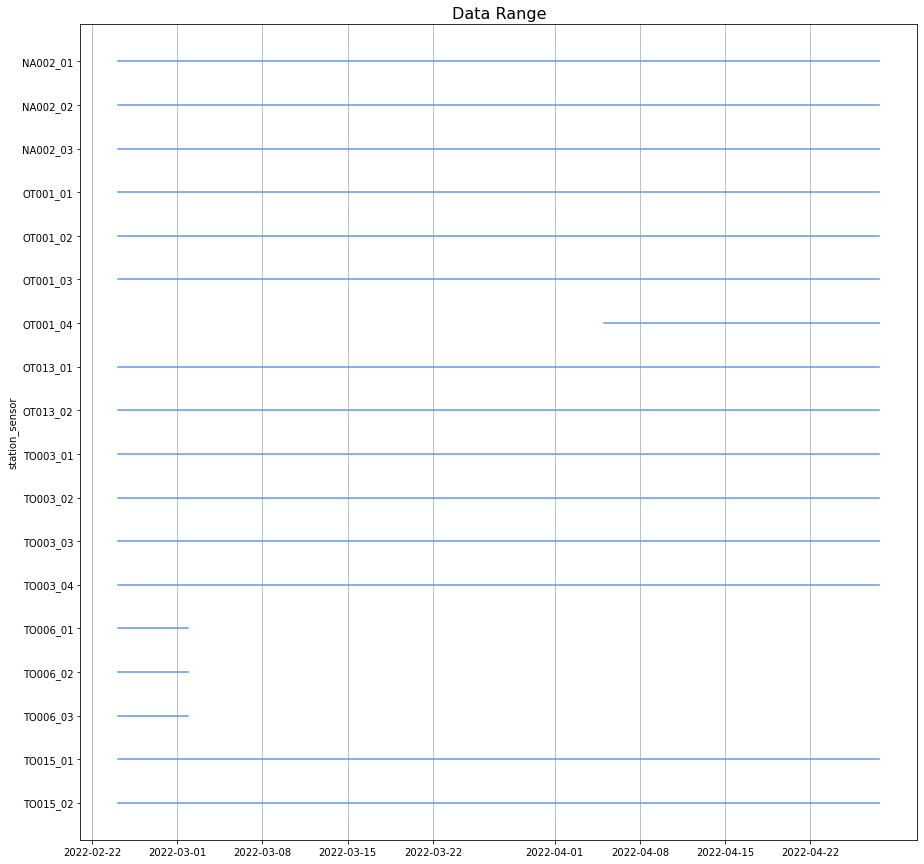

In [24]:
fig,ax = plt.subplots(figsize=(15,15))

#setting different variables, x1=earliest record, x2=latest record, y=position and c=colours of lines.
#when using ax.plot, we are going from the earliest to the latest record on the x-axis, and the y-axis is set by
#position.
for x1, x2, y in zip(snapsorted['earliestrecord'], snapsorted['latestrecord'], snapsorted['pos']):
    ax.plot([x1, x2], [y, y], color='cornflowerblue')

#label y-axis with station_type name
ax.set_yticks(yvals)
ax.set_yticklabels(station_list)

ax.grid(axis='x')

ax.set_title('Data Range', fontsize=16)
ax.set_ylabel('station_sensor');